## Dependencies

In [17]:
# Import Dependencies
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import joblib
import numpy as np
import pandas as pd
import requests

## Get Player Data

In [2]:
# Player data from URL
results = requests.get("http://nhl-app.eba-tmaqptju.us-west-2.elasticbeanstalk.com/api/avgplayerstats/all").json()

In [3]:
# Create Dataframe of player data
df = pd.DataFrame()
pid_list = []
pos_list = []
toi_list = []
g_list = []
a_list = []
s_list = []
h_list = []
ppg_list = []
ppa_list = []
pim_list = []
fow_list = []
fot_list = []
ta_list = []
ga_list = []
shg_list = []
sha_list = []
bs_list = []
etoi_list = []
shtoi_list = []
pptoi_list = []
for player in results:
    pid_list.append(player['player_id'])
    pos_list.append(player['Position'][-1])
    toi_list.append(player['timeOnIce'])
    a_list.append(player['assists'])
    g_list.append(player['goals'])
    s_list.append(player['shots'])
    h_list.append(player['hits'])
    ppg_list.append(player['powerPlayGoals'])
    ppa_list.append(player['powerPlayAssists'])
    pim_list.append(player['penaltyMinutes'])
    fow_list.append(player['faceOffWins'])
    fot_list.append(player['faceoffTaken'])
    ta_list.append(player['takeaways'])
    ga_list.append(player['Expr1'])
    shg_list.append(player['shortHandedGoals'])
    sha_list.append(player['shortHandedAssists'])
    bs_list.append(player['blocked'])
    etoi_list.append(player['evenTimeOnIce'])
    shtoi_list.append(player['shortHandedTimeOnIce'])
    pptoi_list.append(player['powerPlayTimeOnIce'])
df["pid"] = pid_list
df["pos"] = pos_list
df["toi"] = toi_list
df["g"] = g_list
df["a"] = g_list
df["s"] = s_list
df["h"] = h_list
df["ppg"] = ppg_list
df["ppa"] = ppa_list
df["pim"] = pim_list
df["fow"] = fow_list
df["fot"] = fot_list
df["ta"] = ta_list
df["ga"] = ga_list
df["shg"] = shg_list
df["sha"] = sha_list
df["bs"] = bs_list
df["etoi"] = etoi_list
df["shtoi"] = shtoi_list
df["pptoi"] = pptoi_list

In [4]:
X_df = df.drop(columns=["pos", "pid"])

In [5]:
# Establish X, y
X = X_df.values
y = df["pos"]

## Create Training and Testing Sets

In [13]:
# Convert Player Positions (C, W, D) to numerical values
label_encoder = LabelEncoder()
label_encoder.fit(y)
encoded_y = label_encoder.transform(y)

In [14]:
## CLASSES
# 0 - C (Center)
# 1 - D (Defense)
# 2 - W (Winger)

In [18]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler

# Standardize the columns
X_scaler = StandardScaler().fit(X)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Import Models

In [21]:
# Import and save models
nn_model = load_model("position_nn_model.h5")
svm_model = joblib.load("position_svm_model.pkl")

## AUC-ROC Curve

In [22]:
from sklearn.metrics import roc_curve

# predict probabilities
pred_prob_nn = nn_model.predict_proba(X_test_scaled)
pred_prob_svm = svm_model.predict_proba(X_test_scaled)

# roc curve for models
fpr_nn, tpr_nn, thresh_nn = roc_curve(y_test, pred_prob_nn[:,1], pos_label=1)
fpr_svm, tpr_svm, thresh_svm = roc_curve(y_test, pred_prob_svm[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

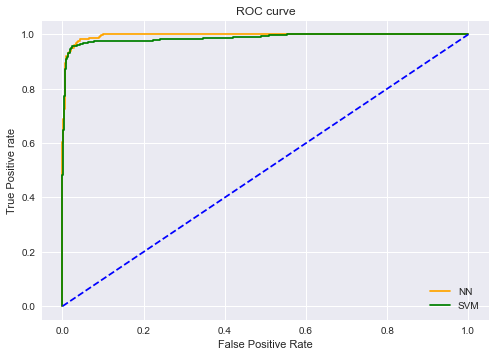

In [25]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr_nn, tpr_nn, color='orange', label='NN')
plt.plot(fpr_svm, tpr_svm, color='green', label='SVM')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('../static/img/model-auc-roc-curve.png',dpi=300)
plt.show()